# FRF_Currituck Sound Station 4: Vertical Diffuse Attenuation Coefficient for Downwelling Photosynthetic Radiance EDA


python netcdf4 documentation: http://unidata.github.io/netcdf4-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4
import time
import datetime

import sklearn.metrics
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Read csv files for station 04, load into a dataframe, and wrangle...

In [15]:
data_path='/Users/paulp/GoogleDrive/projects/CurrituckSnd/CS_Stations/'

CS04_WQb=pd.read_csv(data_path+'CS04/FRF_CS04-DTS12-bot.csv', na_values=-999.990)
CS04_WQt=pd.read_csv(data_path+'CS04/FRF_CS04-DTS12-top.csv', na_values=-999.990)

CS04_WV=pd.read_csv(data_path+'CS04/FRF_CS04-SBE26_Waves_ALL.csv', na_values=-999.990)
CS04_WC=pd.read_csv(data_path+'CS04/FRF_CS04-ADOP_Currents_ALL.csv', na_values=-999.990)

## Set date time values to Python datetime types, and round to nearest 1 second, on UT coordinated...
CS04_WQb['datetime'] = pd.to_datetime(CS04_WQb['datetime'], utc=True).dt.round('1s')
CS04_WQt['datetime'] = pd.to_datetime(CS04_WQt['datetime'], utc=True).dt.round('1s')
CS04_WV['datetime'] = pd.to_datetime(CS04_WV['datetime'], utc=True).dt.round('1s')
CS04_WC['datetime'] = pd.to_datetime(CS04_WC['datetime'], utc=True).dt.round('1s')


## Assign datetime field to data frame index
CS04_WQb.set_index('datetime', inplace=True)
CS04_WQt.set_index('datetime', inplace=True)
CS04_WV.set_index('datetime', inplace=True)
CS04_WC.set_index('datetime', inplace=True)

## Aggregate sensor record indices in each of the three dataframes to the full day
CS04_WQb=CS04_WQb.resample('D').mean().copy()
CS04_WQt=CS04_WQt.resample('D').mean().copy()
CS04_WV=CS04_WV.resample('D').mean().copy()
CS04_WC=CS04_WC.resample('D').mean().copy()

CS04 = pd.concat([CS04_WQb,CS04_WQt,CS04_WV,CS04_WC]).drop(['aveE','aveN','currentDirection','meanPressure','wavePeakFrequency'],
                                                           axis=1)
CS04.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2267 entries, 2016-02-02 to 2017-11-29
Data columns (total 5 columns):
currentSpeed       487 non-null float64
depth              703 non-null float64
turbidity_lower    180 non-null float64
turbidity_upper    710 non-null float64
waveHs             695 non-null float64
dtypes: float64(5)
memory usage: 106.3 KB


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



### Some initial 'looks' at the Kd data:

### Station Summary:

In [19]:
CS04.describe()

,currentSpeed,depth,turbidity_lower,turbidity_upper,waveHs
count,487.000000,703.000000,180.000000,710.000000,695.000000
mean,0.074202,2.631616,21.004678,9.737139,0.169103
std,0.033125,0.190545,21.037880,10.715021,0.087168
min,0.022232,1.947046,3.672120,0.000000,0.026978
25%,0.056106,2.504804,7.846486,3.199454,0.108562
50%,0.066569,2.646625,13.718741,6.407488,0.153588
75%,0.086311,2.772445,24.257795,12.099817,0.211627
max,0.353647,3.062694,136.963592,67.785944,0.665266


In [ ]:
{'water_temp': [19.587210,21.359987,18.475558,,], 'salinity': [2.559371,2.414230,1.847649,,], 'pH': [8.182356,8.125634,,,], 
 'turbidity': [14.723885,14.312783,20.433143,9.737139],
 'chlorophyll': [9.422746,9.610058,,,],
                    'DOsat':[106.782628,104.803038,,,], 'DOmass': [9.838875,9.286667,,,], 'blueGreenAlgae': [20.616158,27.164130,,,], 
 'fDOM':[85.149616,66.421834,,], 
                    'waveHs':[0.228047,0.202883,0.140811,0.169103], 'currents':[0.100759,0.082455,0.278409] }

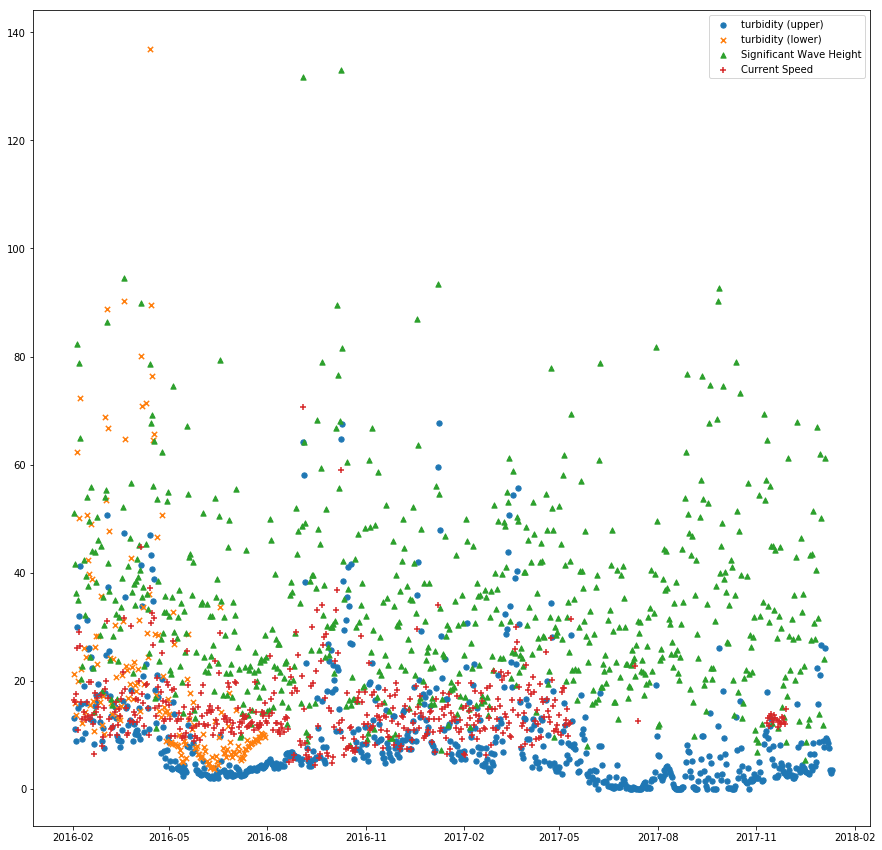

In [20]:
plt.subplots(figsize=(15,15))
    
plt.scatter(CS04.index, CS04['turbidity_upper'], s=28, marker='o', label='turbidity (upper)')
plt.scatter(CS04.index, CS04['turbidity_lower'], s=28, marker='x', label='turbidity (lower)')
plt.scatter(CS04.index, CS04['waveHs']*200, s=28, marker='^', label='Significant Wave Height')
plt.scatter(CS04.index, CS04['currentSpeed']*200, s=28, marker='+', label='Current Speed')
plt.legend()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


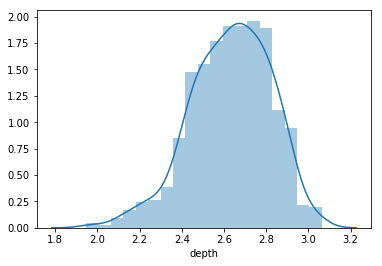

In [43]:
sns.distplot(CS04['depth'].dropna(how='all'))

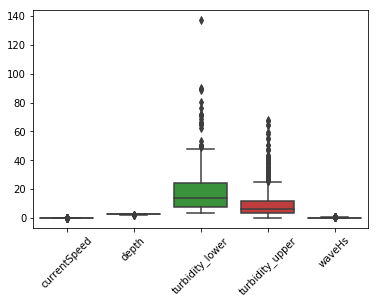

In [24]:
sns.boxplot(data=CS04)
plt.tick_params(axis='x', rotation=45)

### The Relationship between Chl-a and blue-green algae  (Chl-a, blue-green algae not measured at Station 04)

Bayley et al., 2003 indicate that Chl-a is a suitable proxy for phytoplankton abundance. Let's see what this relationship might look like for Currituck Sound

In [40]:
CS04.dropna(how='all').corr()

,currentSpeed,depth,turbidity_lower,turbidity_upper,waveHs
currentSpeed,1.0,NaN,NaN,NaN,NaN
depth,NaN,1.000000,NaN,NaN,-0.252775
turbidity_lower,NaN,NaN,1.0,NaN,NaN
turbidity_upper,NaN,NaN,NaN,1.0,NaN
waveHs,NaN,-0.252775,NaN,NaN,1.000000


### Downwelling Diffuse Radiation Attenuation Coefficient - $K_d$ - _Linear_ Correlation Matrix

All station data included (less upper and lower PAR metrics)  

Annotations in matrix are Pearson Product Moment (r) statistics:

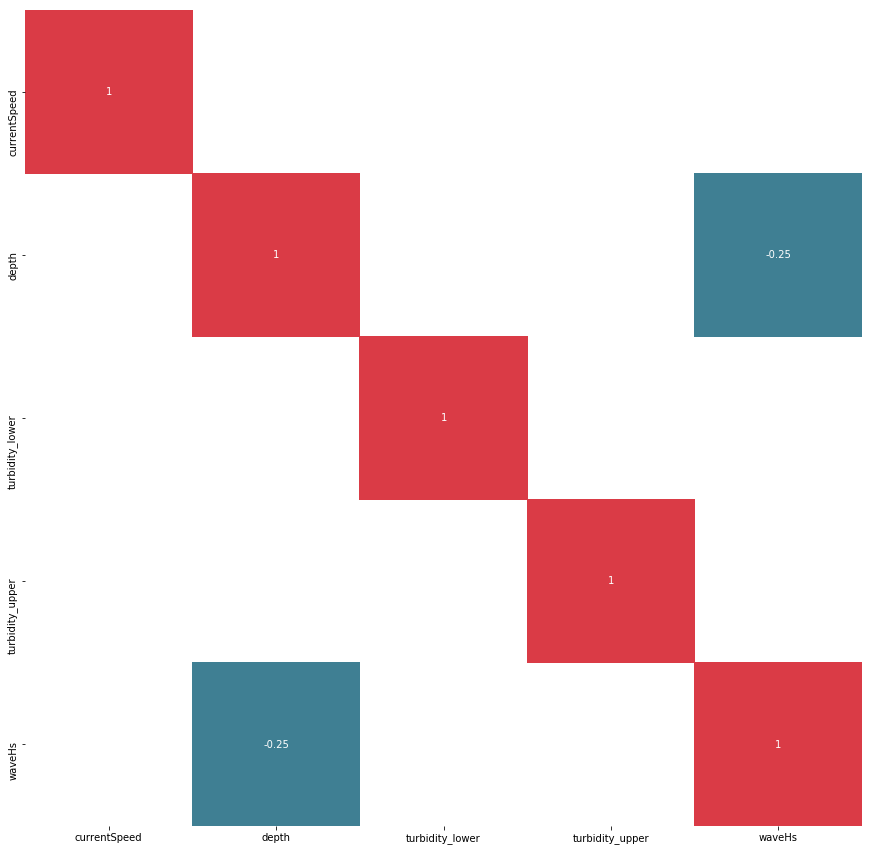

In [27]:
plt.subplots(figsize=(15,15) )
cmap = sns.diverging_palette(220, 10, center='light', as_cmap=True)
sns.heatmap( CS04.corr(), cbar=False, annot=True, cmap=cmap )

### Downwelling Diffuse Radiation Attenuation Coefficient - $K_d$ - OLS _Exploratory_ Regression Plots

and its relationship to [assumed] controlling factors: surface waves, unidirectional currents, fDOM, Turbidity, and Chl-a 

$K_{d_{total}} = K_{d_{H_2O}} + K_{d_{fDOM}} + K_{d_{Chi-a}} + K_{d_{turbidity}}$

where: <br>
$K_{d_{H_2O}}$ is the optical density of water (not considered here) <br>
$K_{d_{fDOM}}$ is the contribution to $K_{d_{total}}$ from non-algal organic particulates <br>
$K_{d_{Chl-a}}$ is the contribution to $K_{d_{total}}$ from Chlorophyll-a (phytoplankton proxy)<br>
$K_{d_{turbidity}}$ is the contribution to $K_{d_{total}}$ from measured water column turbidity (total suspended inorganic particles)<br>
$K_{d_{surface waves}}$ is the contribution to $K_{d_{total}}$ directly and indirectly attributable to surface waves <br>
$K_{d_{currents}}$ is the contribution to $K_{d_{total}}$ from unidirectional water current(s) <br>

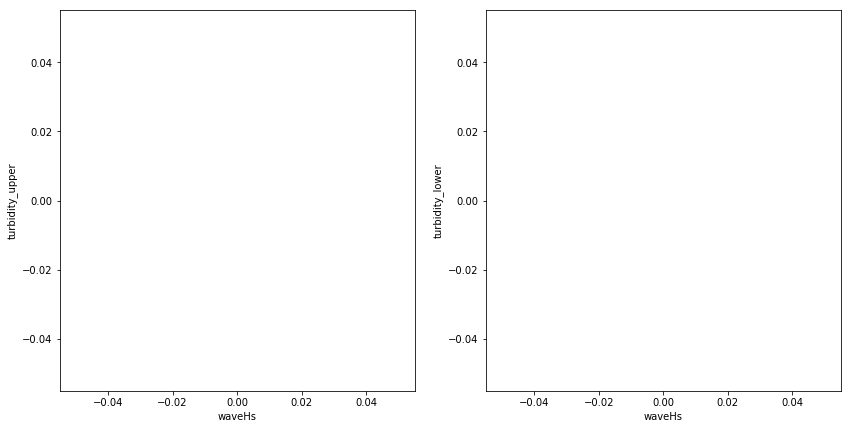

In [46]:

fig2=plt.figure(figsize=(14,7))
sns.regplot(x='waveHs', y='turbidity_upper', data=CS04, fit_reg=False, order=1, ax=fig2.add_subplot(1,2,1))
sns.regplot(x='waveHs', y='turbidity_lower', data=CS04, fit_reg=False, order=1, ax=fig2.add_subplot(1,2,2))

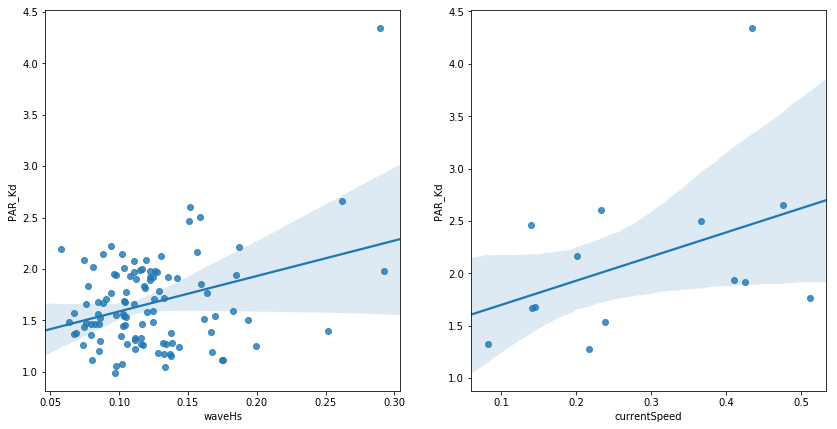

In [15]:
fig3=plt.figure(figsize=(14,7))

sns.regplot(x='waveHs', y='PAR_Kd', data=CS03, ax=fig3.add_subplot(1,2,1))
sns.regplot(x='currentSpeed', y='PAR_Kd', data=CS03, order=1, ax=fig3.add_subplot(1,2,2))

In [16]:
CS03['waveHs'].describe()

count    314.000000
mean       0.140811
std        0.071714
min        0.031490
25%        0.094102
50%        0.123730
75%        0.168001
max        0.610474
Name: waveHs, dtype: float64

#### What if we could somehow remove the high-wind and storm wave effect from the data? 
#### How much might this attempt to isolate "typical" conditions impact results?

The 75th quantile for the significant wave height is 0.168001 m. So, 75% of the waves recorded at Station 03 are < 0.17 m. Though arbitrary, what if we assume (for now) that this 75% condition marks the upper boundary of "typical" wave energy conditions on Currituck Sound?

In [18]:
CS03_=CS03[CS03['waveHs'] < 0.17 ]

,PAR_Kd,turbidity_upper,turbidity_lower
PAR_Kd,1.000000,0.877240,0.782471
turbidity_upper,0.877240,1.000000,0.976529
turbidity_lower,0.782471,0.976529,1.000000


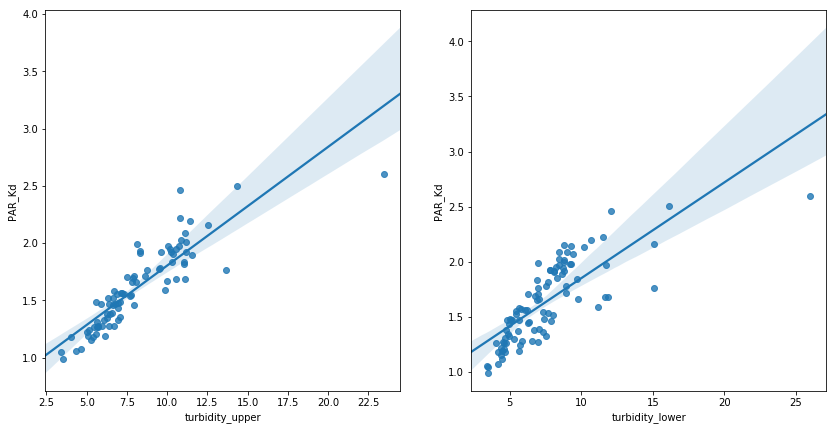

In [20]:
fig4=plt.figure(figsize=(14,7))
sns.regplot(x='turbidity_upper', y='PAR_Kd', data=CS03_, fit_reg=True, order=1, ax=fig4.add_subplot(1,2,1))
sns.regplot(x='turbidity_lower', y='PAR_Kd', data=CS03_, fit_reg=True, order=1, ax=fig4.add_subplot(1,2,2))

CS03_[['PAR_Kd', 'turbidity_upper','turbidity_lower']].corr()

,PAR_Kd,waveHs,currentSpeed
PAR_Kd,1.000000,0.124646,0.188285
waveHs,0.124646,1.000000,0.281587
currentSpeed,0.188285,0.281587,1.000000


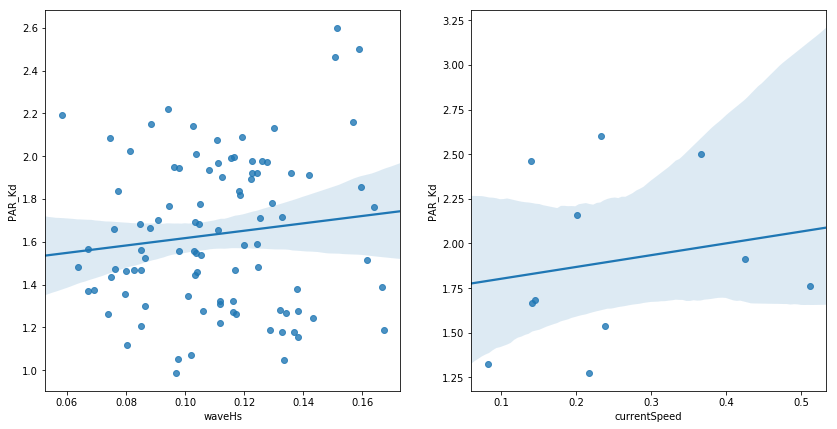

In [21]:
fig5=plt.figure(figsize=(14,7))

sns.regplot(x='waveHs', y='PAR_Kd', data=CS03_, ax=fig5.add_subplot(1,2,1))
sns.regplot(x='currentSpeed', y='PAR_Kd', data=CS03_, order=1, ax=fig5.add_subplot(1,2,2))

CS03_[['PAR_Kd','waveHs','currentSpeed']].corr()

### Multiple Regression Experiment:

In [26]:
#Instantiate the regression model and setting parameters if any,
reg_model = LinearRegression(normalize=True)

R=CS03[['turbidity_upper','turbidity_lower','waveHs','currentSpeed','PAR_Kd']].dropna()
X=R[['turbidity_upper','turbidity_lower','waveHs','currentSpeed']]
y=R[['PAR_Kd']]

reg_model.fit(X, y)

P=reg_model.predict(X)

#outputs the coefficients
print('Intercept :', reg_model.intercept_[0], '\n')
print(pd.DataFrame({'features':X.columns,'coeficients':reg_model.coef_[0]}))

print("R^2: {:.2f}".format(reg_model.score(X, y)))

Intercept : 0.09142133044665357 

          features  coeficients
0  turbidity_upper     0.278906
1  turbidity_lower    -0.193248
2           waveHs    10.237080
3     currentSpeed    -1.378384
R^2: 0.90


Text(0,0.5,'Observed Kd')

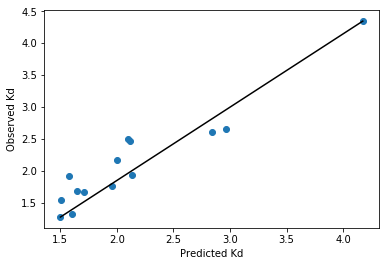

In [27]:
plt.scatter(P,R['PAR_Kd'])
plt.plot([P.min(),P.max()],[R['PAR_Kd'].min(), R['PAR_Kd'].max()], c='black')
plt.xlabel('Predicted Kd')
plt.ylabel('Observed Kd')

In [29]:
import statsmodels.api as sm

model03 = sm.OLS(y, sm.add_constant(X)).fit()
model03.summary()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PAR_Kd   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     19.71
Date:                Tue, 07 Aug 2018   Prob (F-statistic):           0.000178
Time:                        11:16:55   Log-Likelihood:              -0.020760
No. Observations:                  14   AIC:                             10.04
Df Residuals:                       9   BIC:                             13.24
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0914      0.345      0.265      0.797      -0.689       0.872
turbidity_upper     0.2789      0.179      1.554      0.155      -0.127       0.685
turbidity_lower    -0.1932      0.163     -1.187      0.266      -0.561       0.175
waveHs             10.2371      3.662      2.796      0.021       1.954      18.520
currentSpeed       -1.3784      0.847     -1.628      0.138      -3.293       0.537
==============================================================================
Omnibus:                        2.933   Durbin-Watson:                   1.745
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                1.263
Skew:                           0.323   Prob(JB):                        0.532
Kurtosis:                       1.678   Cond. No.                     1.02e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regressing under "typical" conditions:

In [30]:
R=CS03_[['turbidity_upper','turbidity_lower','waveHs','currentSpeed',
                                'PAR_Kd']].dropna()
X=R[['turbidity_upper','turbidity_lower','waveHs','currentSpeed']]
y=R[['PAR_Kd']]
model11 = sm.OLS(y, sm.add_constant(X)).fit()
model11.summary()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 PAR_Kd   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     5.169
Date:                Tue, 07 Aug 2018   Prob (F-statistic):             0.0378
Time:                        11:20:59   Log-Likelihood:                 1.4105
No. Observations:                  11   AIC:                             7.179
Df Residuals:                       6   BIC:                             9.169
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4972      0.932     -0.533      0.613      -2.778       1.784
turbidity_upper     0.3075      0.300      1.027      0.344      -0.425       1.041
turbidity_lower    -0.2397      0.275     -0.870      0.418      -0.914       0.434
waveHs             17.3395      9.266      1.871      0.110      -5.335      40.014
currentSpeed       -1.6418      1.158     -1.417      0.206      -4.476       1.193
==============================================================================
Omnibus:                        2.260   Durbin-Watson:                   2.747
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                1.103
Skew:                          -0.407   Prob(JB):                        0.576
Kurtosis:                       1.680   Cond. No.                     1.97e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""